# Defines

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from scipy.optimize import root
I = np.eye(3)
O = np.zeros((3, 3))

# Contmecha formulas

### Rates of change

Velocity gradient:
$$\boldsymbol{l} = \text{grad}\boldsymbol{v}$$
Rate of deformation:
$$\boldsymbol{d} = \text{symm}(\boldsymbol{l}) = \frac{1}{2}(\boldsymbol{l}+\boldsymbol{l}^T)$$
Spin tensor:
$$\boldsymbol{w} = \text{skew}(\boldsymbol{l}) = \frac{1}{2}(\boldsymbol{l}-\boldsymbol{l}^T)$$

# Simple shear

$$
[F] = 
\begin{bmatrix}
    1 & \gamma & 0 \\
    0 & 1 & 0 \\
    0 & 0 & 1 \\
\end{bmatrix}
\quad\Rightarrow\quad
[F^{-1}] = 
\begin{bmatrix}
    1 & -\gamma & 0 \\
    0 & 1 & 0 \\
    0 & 0 & 1 \\
\end{bmatrix}
$$

In [25]:
N = 1000
t = np.linspace(0,1,N)

gamma  = lambda t: 4*t
dgamma = lambda t: 4

$$
[l] = [\dot{F}F^{-1}] = 
\begin{bmatrix}
    0 & \dot{\gamma}(t) & 0 \\
    0 & 0 & 0 \\
    0 & 0 & 0 \\
\end{bmatrix}
$$

In [26]:
l = lambda t : np.array([[0,dgamma(t),0],[0,0,0],[0,0,0]])

$$
d = \frac{1}{2}(l+l^T) \quad\&\quad w = l - d
$$

In [27]:
d = lambda t: 1/2 * (l(t)+l(t).T)
w = lambda t: l(t) - d(t)

## Radial return algorithm

Hooke's law:
$$
\overset{\circ}{\sigma} = \mathbb{D} : d 
\quad\Rightarrow\quad
\overset{\circ}{\sigma} = \frac{E}{1+\nu}\left(d+\frac{\nu}{1-2\nu}(\text{tr}d)I\right)
$$

In [61]:
E = 200e9
nu = 0.3
G = E/2/(1+nu)

D = lambda d: E/(1+nu) * (d + nu/(1-2*nu)*np.trace(d)*I)

Yield curve:
$$
Y(\lambda) = a(\varepsilon_0+\lambda)^n
$$

In [62]:
a = 500e6
eps_0  = 0.0003
k = 0.2

Y_F = lambda λ : a*(eps_0 + λ)**k

In [63]:
dev = lambda M : M - np.trace(M) / 3 * I
norm = lambda M : np.sqrt(np.sum(M**2)) # TODO: Check if it's good!

In [64]:
Q = np.tile(I, (N, 1, 1))
sig_tilde = np.tile(O, (N, 1, 1))
sig = np.tile(O, (N, 1, 1))
Y = np.ones(N) * Y_F(0)
λ = np.zeros(N)

for n in range(N-1):
    dt = t[n+1] - t[n]
    t_mid = t[n]+dt/2

    # Hughes-Winget
    Q[n+1] = inv(I - 1/2*w(t_mid)*dt) @ (I + 1/2*w(t_mid)*dt) @ Q[n]
    Q_mid = Q[n+1] # Kossa mondta a videóban, hogy nem kell a középső lépés

    deps_tilde = Q_mid.T @ d(t_mid)* dt @ Q_mid

    # Step 3: trial stress
    sig_trial_tilde = sig_tilde[n] + D(deps_tilde)
    s_trial_tilde = dev(sig_trial_tilde)

    # Step 4: trial yield function
    F_trial = (3/2)**(1/2) * norm(s_trial_tilde) - Y[n]

    if F_trial <= 0:
        # Step 6: Elastic increment
        sig_tilde[n+1] = sig_trial_tilde
        Y[n+1] = Y[n]
        λ[n+1] = λ[n]
    else:
        # Step 7: Accumulated plastic strain increment
        def eq(dλ):
            ret  = (3/2)**(1/2) * norm(s_trial_tilde)
            ret -= 3*G*dλ
            ret -= Y_F(λ[n]+dλ)
            return ret
        dλ = (root(eq,1e-8).x)[0]
        # Step 8: Plastic strain increment and yield stress update
        deps_p_tilde = (3/2)**(1/2) * dλ * s_trial_tilde / norm(s_trial_tilde)
        λ[n+1] = λ[n] + dλ
        Y[n+1] = Y_F(λ[n+1])
        # Step 9: Update the rotated stress
        sig_tilde[n+1] = sig_trial_tilde - D(deps_p_tilde)
    
    # Step 10: Compute the stress tensor
    sig[n+1] = Q[n+1] @ sig_tilde[n+1] @ Q[n+1].T


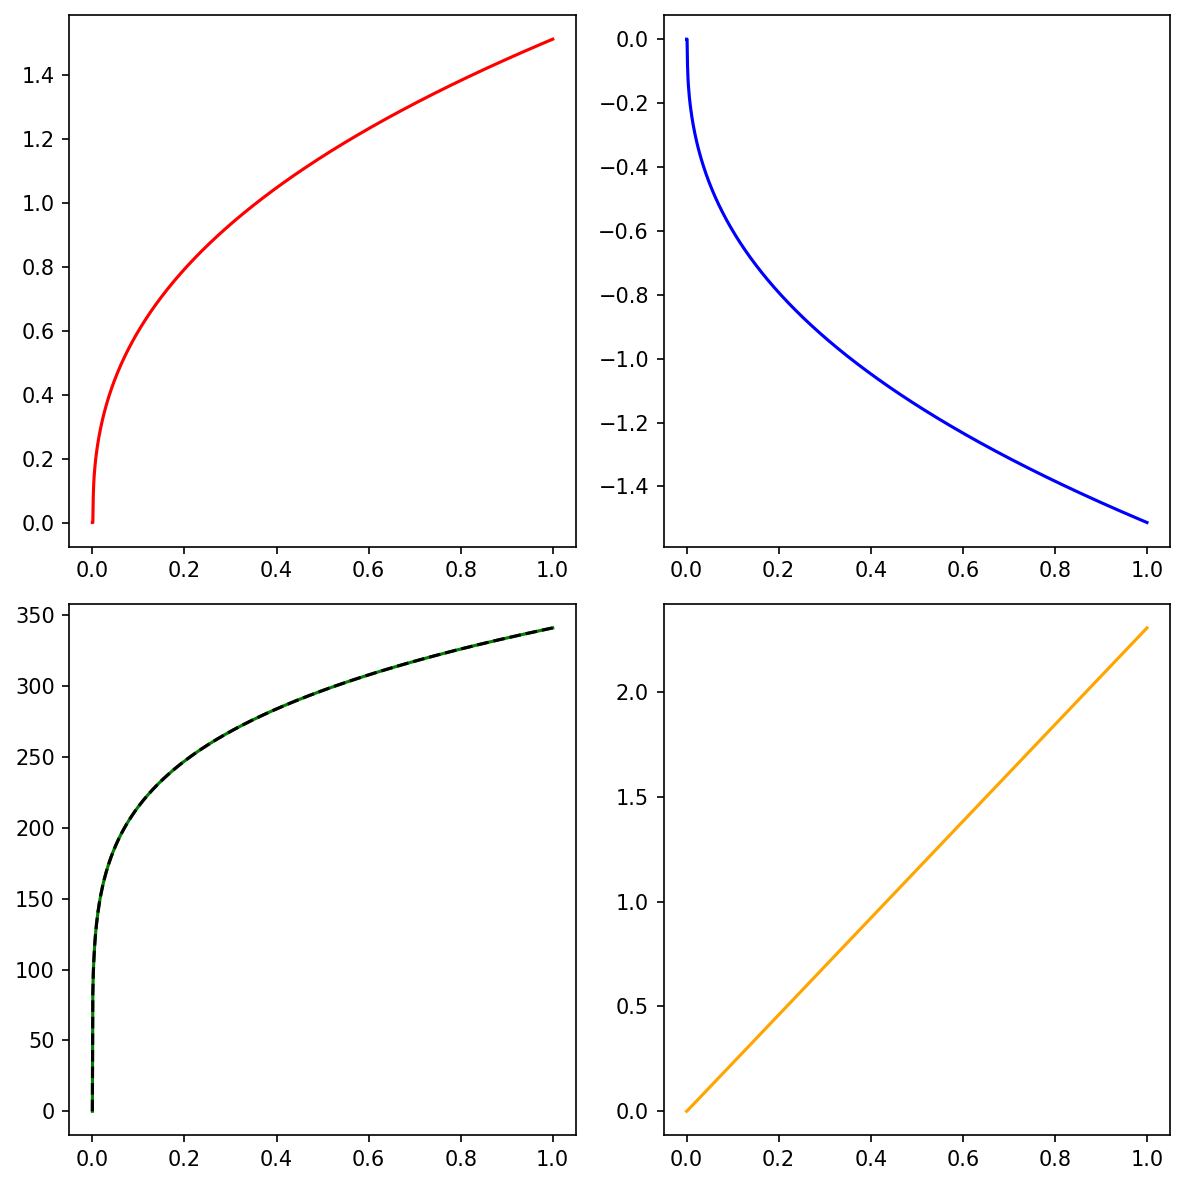

In [67]:
fig, ax = plt.subplots(2,2,figsize=(8,8),dpi=150)

ax[0,0].plot(t,sig[:,0,0]/1e6,label=r'$\sigma_x$',color='red')
ax[0,1].plot(t,sig[:,1,1]/1e6,label=r'$\sigma_x$',color='blue')
ax[1,0].plot(t,sig[:,1,0]/1e6,label=r'$\sigma_x$',color='green')
ax[1,0].plot(t,sig[:,0,1]/1e6,label=r'$\sigma_x$',color='black',ls='--')
ax[1,1].plot(t,λ,label=r'$\sigma_x$',color='orange')

plt.tight_layout()
plt.show()